In [11]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Transformasi dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST
train_dataset = datasets.FashionMNIST(
    root='datasets/fashion_mnist',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.FashionMNIST(
    root='fashion_mnist',
    train=False,
    download=True,
    transform=transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
import torch

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Pilih GPU pertama (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA GeForce GTX 1650


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, kernel_size, pooling_type):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool2d(2) if pooling_type == "max" else nn.AvgPool2d(2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
def train_model(model, optimizer, criterion, train_loader, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate_model(model, criterion, test_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy


In [18]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"Model improved. Saving current model to {self.path}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter grid
kernel_sizes = [3, 5, 7]
pooling_types = ["max", "avg"]
optimizers = ["SGD", "RMSProp", "Adam"]
epochs_list = [5, 50, 100, 250, 350]

results = []

for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print(f"Training with Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer_name}, Epochs={num_epochs}")

                model = CNN(kernel_size, pooling_type).to(device)
                criterion = nn.CrossEntropyLoss()
                if optimizer_name == "SGD":
                    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == "RMSProp":
                    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == "Adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

                early_stopping = EarlyStopping(patience=10, delta=0.001, path=f'D:\Kuliah\KULIAH - TK4505\Semester 7\ML\Machine-Learning-Class-Merge\Minggu 12\PYTorch\MNIST\model_{kernel_size}_{pooling_type}_{optimizer_name}.pth')

                train_losses = []g
                val_losses = []
                val_accuracies = []

                for epoch in range(num_epochs):
                    train_loss = train_model(model, optimizer, criterion, train_loader, device)
                    val_loss, val_accuracy = validate_model(model, criterion, test_loader, device)

                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    val_accuracies.append(val_accuracy)

                    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

                    early_stopping(val_loss, model)
                    if early_stopping.early_stop:
                        print("Early stopping triggered!")
                        break

                results.append({
                    "Kernel Size": kernel_size,
                    "Pooling": pooling_type,
                    "Optimizer": optimizer_name,
                    "Epochs": num_epochs,
                    "Best Val Accuracy": max(val_accuracies),
                    "Best Val Loss": min(val_losses)
                })

results_df = pd.DataFrame(results)
results_df.to_csv('fashion_mnist_results.csv', index=False)


Training with Kernel=3, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 0.8895, Val Loss: 0.6905, Val Accuracy: 74.62%
Model improved. Saving current model to model_3_max_SGD.pth
Epoch 2/5, Train Loss: 0.5279, Val Loss: 0.5005, Val Accuracy: 81.43%
Model improved. Saving current model to model_3_max_SGD.pth
Epoch 3/5, Train Loss: 0.4508, Val Loss: 0.5037, Val Accuracy: 81.72%
Epoch 4/5, Train Loss: 0.4038, Val Loss: 0.4207, Val Accuracy: 84.82%
Model improved. Saving current model to model_3_max_SGD.pth
Epoch 5/5, Train Loss: 0.3752, Val Loss: 0.4292, Val Accuracy: 83.50%
Training with Kernel=3, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 0.9588, Val Loss: 0.7340, Val Accuracy: 70.11%
Model improved. Saving current model to model_3_max_SGD.pth
Epoch 2/50, Train Loss: 0.5064, Val Loss: 0.5043, Val Accuracy: 81.82%
Model improved. Saving current model to model_3_max_SGD.pth
Epoch 3/50, Train Loss: 0.4354, Val Loss: 0.4500, Val Accuracy: 83.64%
Model improved

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded CSV file
csv_file_path = 'fashion_mnist_results.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the data to understand its structure
data.head()


,Kernel Size,Pooling,Optimizer,Epochs,Best Val Accuracy,Best Val Loss
0,3,max,SGD,5,84.82,0.420740
1,3,max,SGD,50,92.02,0.230514
2,3,max,SGD,100,91.97,0.238747
3,3,max,SGD,250,92.02,0.241328
4,3,max,SGD,350,91.79,0.243232


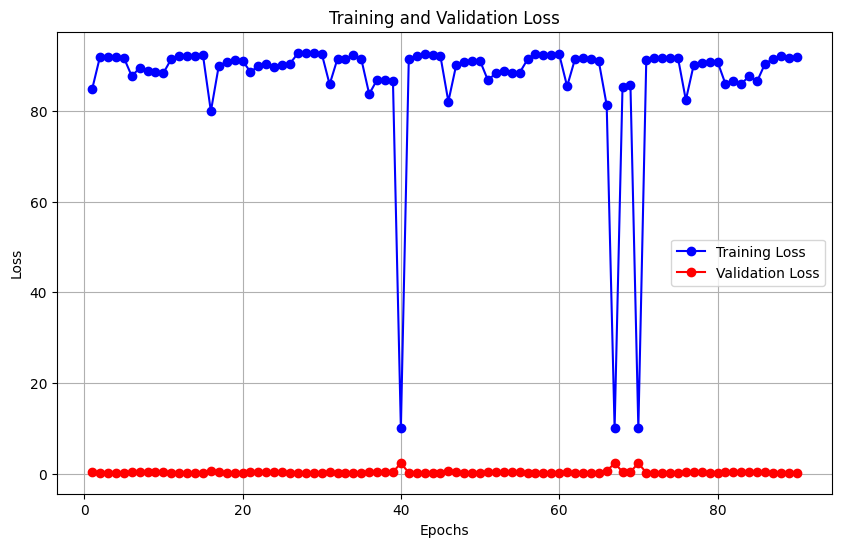

In [41]:
import matplotlib.pyplot as plt

# Contoh: Mengambil kolom train_loss dan val_loss
train_loss = data['Best Val Accuracy']
val_loss = data['Best Val Loss']
epochs = range(1, len(train_loss) + 1)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
import pandas as pd

# Lokasi file hasil eksperimen
results_path = 'fashion_mnist_results.csv'

# Baca file CSV
df = pd.read_csv(results_path)

# Urutkan berdasarkan akurasi terbaik
top_10_results = df.sort_values(by='Best Val Accuracy', ascending=False).head(10)

# Tampilkan DataFrame hasil
print(top_10_results[['Kernel Size', 'Pooling', 'Optimizer', 'Epochs', 'Best Val Accuracy']])


    Kernel Size Pooling Optimizer  Epochs  Best Val Accuracy
27            3     avg      Adam     100              92.86
26            3     avg      Adam      50              92.75
28            3     avg      Adam     250              92.70
29            3     avg      Adam     350              92.68
42            5     max      Adam     100              92.61
59            5     avg      Adam     350              92.53
56            5     avg      Adam      50              92.48
57            5     avg      Adam     100              92.45
33            5     max       SGD     250              92.39
58            5     avg      Adam     250              92.35


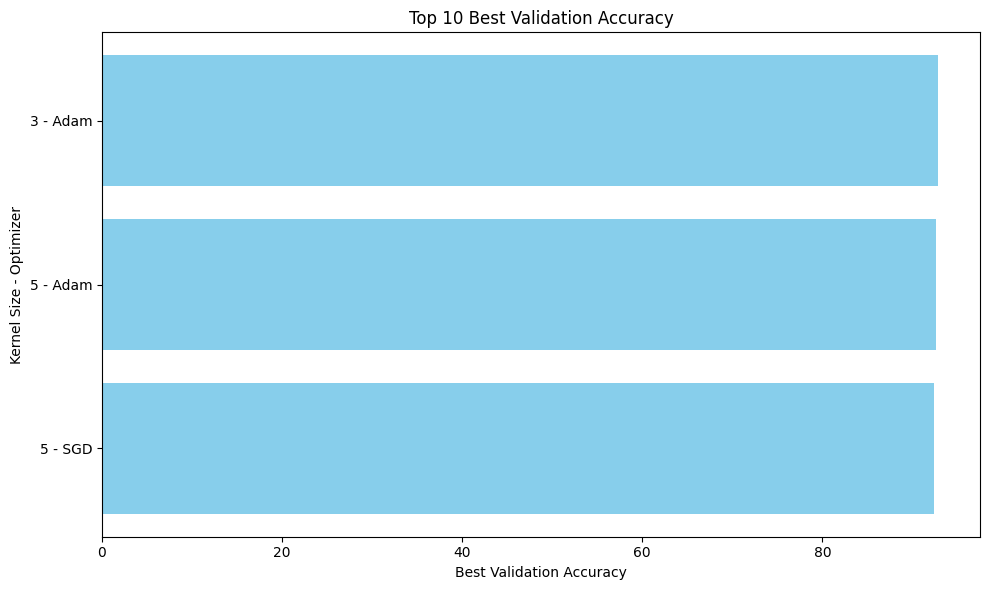

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Lokasi file hasil eksperimen
results_path = 'fashion_mnist_results.csv'

# Baca file CSV
df = pd.read_csv(results_path)

# Urutkan berdasarkan akurasi terbaik
top_10_results = df.sort_values(by='Best Val Accuracy', ascending=False).head(10)

# Membuat barplot
plt.figure(figsize=(10, 6))
plt.barh(top_10_results['Kernel Size'].astype(str) + ' - ' + top_10_results['Optimizer'], 
         top_10_results['Best Val Accuracy'], color='skyblue')
plt.xlabel('Best Validation Accuracy')
plt.ylabel('Kernel Size - Optimizer')
plt.title('Top 10 Best Validation Accuracy')
plt.gca().invert_yaxis()  # Membalik urutan agar yang terbaik di atas
plt.tight_layout()

# Menampilkan plot
plt.show()